In [16]:
import pandas as pd
import numpy as np

In [8]:
genesMapping = pd.read_csv('../processed_data/genesMappingGO.csv')
goTermsDescription = pd.read_csv('../processed_data/goDescription.csv')

In [9]:
genesMapping.goId = genesMapping.goId.apply(lambda x: eval(x))
genesMapping.head()

,gene,goId
0,AAC1,"[GO:0005471, GO:0006783, GO:0006783, GO:000683..."
1,AAC3,"[GO:0005471, GO:0005471, GO:0009061, GO:000906..."
2,AAD10,"[GO:0047681, GO:0006081, GO:0005575, GO:004783..."
3,AAD14,"[GO:0047681, GO:0047681, GO:0006081, GO:000557..."
4,AAD15,"[GO:0047681, GO:0006081, GO:0005575, GO:004783..."


In [11]:
goTermsDescription.head()

,goId,goDescription,family
0,GO:0003674,ER membrane protein involved in regulation of ...,F
1,GO:0017116,Ubiquitin-conjugating enzyme (E2),F
2,GO:0120133,Ser/Thr protein kinase,P
3,GO:0003724,ATP-dependent DEAD-box RNA helicase with stran...,F
4,GO:0015035,Gamma subunit of the oligosaccharyltransferase...,F


In [34]:
goTermsDescription.size

134508

In [14]:
familyMapping = goTermsDescription[['family', 'goId']].set_index('goId').to_dict()['family']

In [86]:
def partitionFamilies(row):
    families = np.array([familyMapping[x] for x in row.goId])
    unique = np.unique(families)
    familiesDict = {}
    for f in unique:
        familiesDict[f] = np.array(row.goId)[families == f].tolist()
    return pd.Series(familiesDict)

families = genesMapping.apply(partitionFamilies, axis=1).applymap(lambda x: [] if not isinstance(x, list) else x)
familiesNum = families.applymap(len).astype(int).rename(
    columns={x: x+'_n' for x in families.columns})
augmentedMapping = pd.concat(
    [genesMapping, families, familiesNum], axis=1)

In [87]:
augmentedMapping.head()

,gene,goId,C,F,P,C_n,F_n,P_n
0,AAC1,"[GO:0005471, GO:0006783, GO:0006783, GO:000683...","[GO:0005743, GO:0005739, GO:0005743, GO:000574...","[GO:0005471, GO:0015297, GO:0005471, GO:000547...","[GO:0006783, GO:0006783, GO:0006839, GO:000906...",10,7,8
1,AAC3,"[GO:0005471, GO:0005471, GO:0009061, GO:000906...","[GO:0005743, GO:0005743, GO:0005739, GO:000573...","[GO:0005471, GO:0005471, GO:0015297, GO:000547...","[GO:0009061, GO:0009061, GO:0009061, GO:001588...",9,8,9
2,AAD10,"[GO:0047681, GO:0006081, GO:0005575, GO:004783...",[GO:0005575],"[GO:0047681, GO:0047834, GO:0016491]",[GO:0006081],1,3,1
3,AAD14,"[GO:0047681, GO:0047681, GO:0006081, GO:000557...",[GO:0005575],"[GO:0047681, GO:0047681, GO:0047834, GO:0016491]",[GO:0006081],1,4,1
4,AAD15,"[GO:0047681, GO:0006081, GO:0005575, GO:004783...",[GO:0005575],"[GO:0047681, GO:0047834, GO:0016491]",[GO:0006081],1,3,1


In [88]:
isInFamily = augmentedMapping[['C_n', 'F_n', 'P_n']] > 0
isInFamily.sum()

C_n    4341
F_n    4311
P_n    4341
dtype: int64

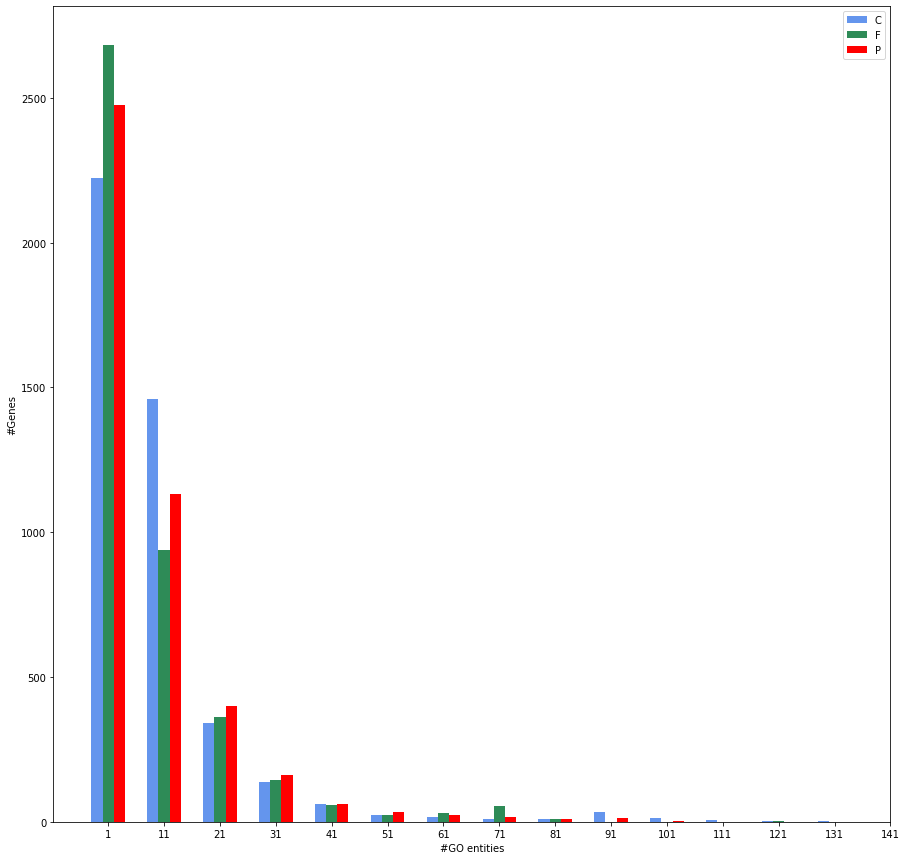

In [105]:

fig, ax = plt.subplots(figsize=(15,15))
ticks = np.arange(1,151,10)
a_heights, a_bins = np.histogram(augmentedMapping['C_n'],bins=ticks)
b_heights, b_bins = np.histogram(augmentedMapping['F_n'], bins=a_bins)
c_heights, c_bins = np.histogram(augmentedMapping['P_n'], bins=a_bins)

width = (a_bins[1] - a_bins[0])/5

ax.bar(a_bins[:-1] - width, a_heights, width=width, facecolor='cornflowerblue', label='C')
ax.bar(b_bins[:-1], b_heights, width=width, facecolor='seagreen', label='F')
ax.bar(c_bins[:-1] + width, c_heights, width=width, facecolor='red', label='P')
plt.xlabel('#GO entities')
plt.ylabel('#Genes')
plt.xticks(ticks)

plt.legend()

In [106]:
fig.savefig('../figures/go_terms_histogram.png')